In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [5]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [6]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [7]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [8]:
df = read_csv_replace_missing_by_polynomial('idh_educacao.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1970,0.343,0.285,0.462,0.49,0.359,0.325,0.647,0.495,0.469,0.292,...,0.505,0.645,0.334,0.472,0.49,0.614,0.6,0.339,0.615,0.342
1980,0.417,0.348,0.54,0.578,0.426,0.411,0.726,0.582,0.564,0.363,...,0.605,0.697,0.422,0.511,0.566,0.675,0.667,0.405,0.674,0.423
1991,0.518,0.442,0.605,0.645,0.511,0.502,0.774,0.661,0.653,0.458,...,0.677,0.749,0.519,0.622,0.618,0.725,0.722,0.515,0.729,0.534
2012,0.649,0.587,0.632,0.659,0.593,0.667,0.768,0.692,0.698,0.611,...,0.718,0.703,0.617,0.637,0.746,0.674,0.74,0.607,0.792,0.676
2013,0.658,0.573,0.659,0.714,0.594,0.667,0.794,0.701,0.71,0.639,...,0.737,0.715,0.642,0.612,0.735,0.691,0.757,0.598,0.8,0.691
2014,0.679,0.599,0.667,0.688,0.619,0.679,0.791,0.709,0.723,0.639,...,0.747,0.736,0.668,0.627,0.757,0.699,0.768,0.625,0.813,0.729
2015,0.679,0.605,0.686,0.69,0.64,0.689,0.789,0.726,0.722,0.649,...,0.747,0.752,0.683,0.664,0.758,0.717,0.769,0.633,0.811,0.707
2016,0.704,0.635,0.705,0.709,0.656,0.708,0.822,0.732,0.754,0.673,...,0.773,0.757,0.676,0.691,0.771,0.722,0.785,0.625,0.837,0.723
2017,0.671,0.634,0.732,0.7,0.655,0.715,0.797,0.731,0.743,0.684,...,0.764,0.762,0.677,0.699,0.764,0.727,0.778,0.639,0.826,0.729
2018,0.706,0.651,0.717,0.742,0.66,0.74,0.808,0.743,0.757,0.685,...,0.777,0.781,0.69,0.705,0.774,0.736,0.78,0.66,0.829,0.741


In [9]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2013)) + list(range(2022,2023))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1970,0.343,0.285,0.462,0.49,0.359,0.325,0.647,0.495,0.469,0.292,...,0.505,0.645,0.334,0.472,0.49,0.614,0.6,0.339,0.615,0.342
1980,0.417,0.348,0.54,0.578,0.426,0.411,0.726,0.582,0.564,0.363,...,0.605,0.697,0.422,0.511,0.566,0.675,0.667,0.405,0.674,0.423
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

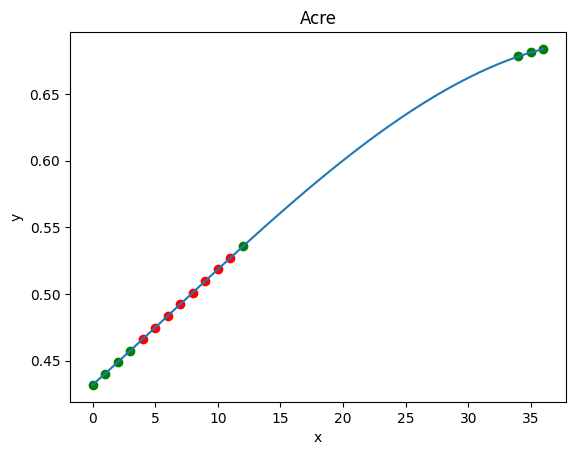

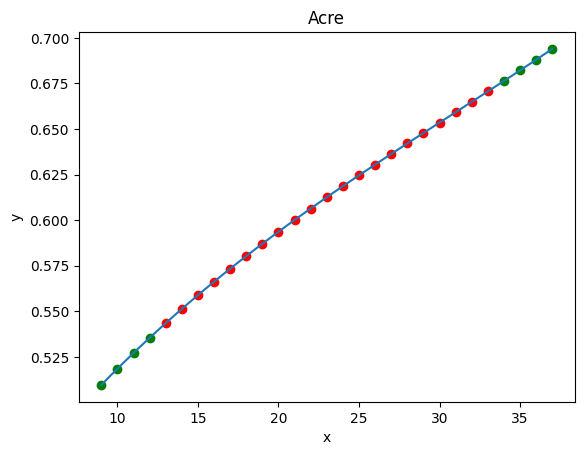

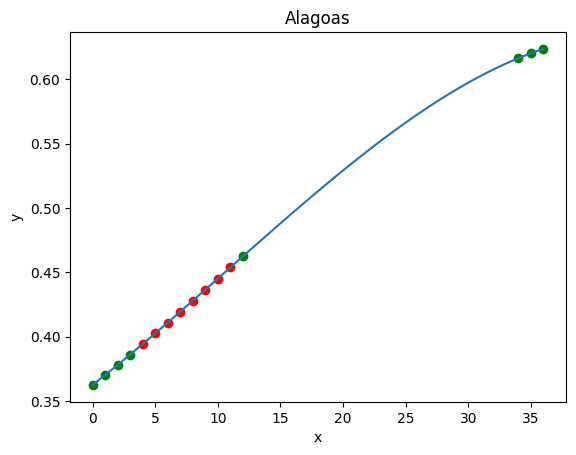

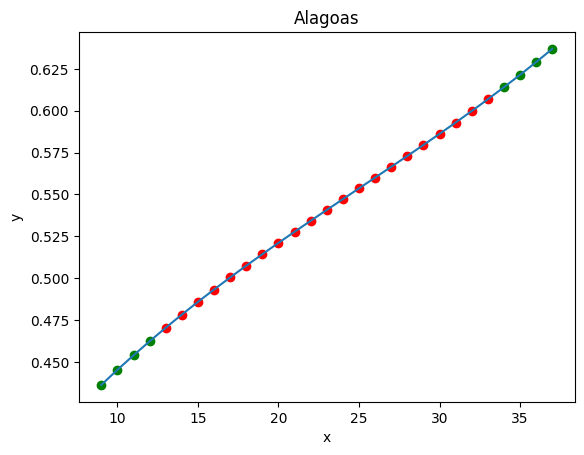

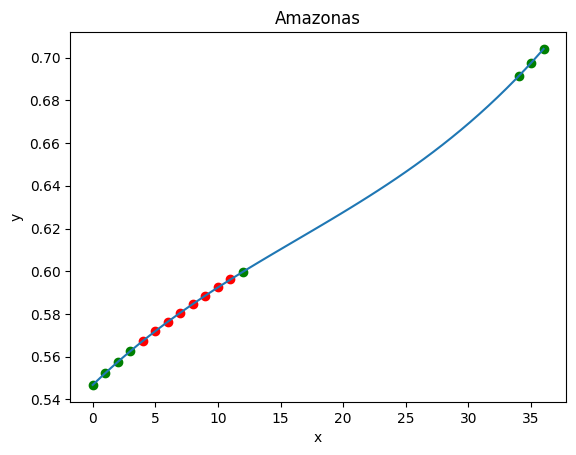

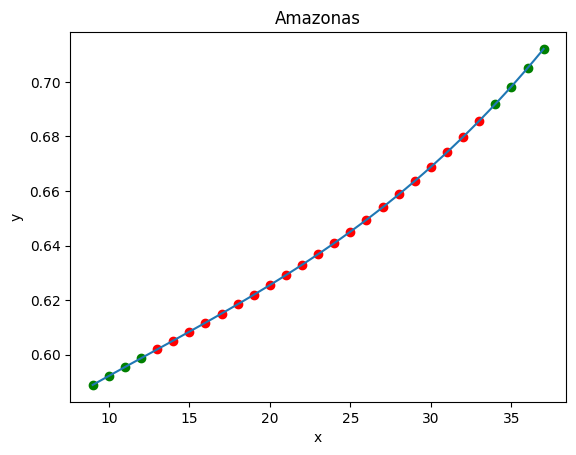

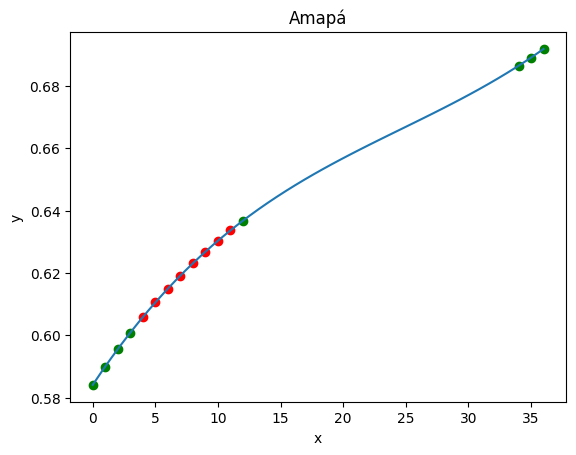

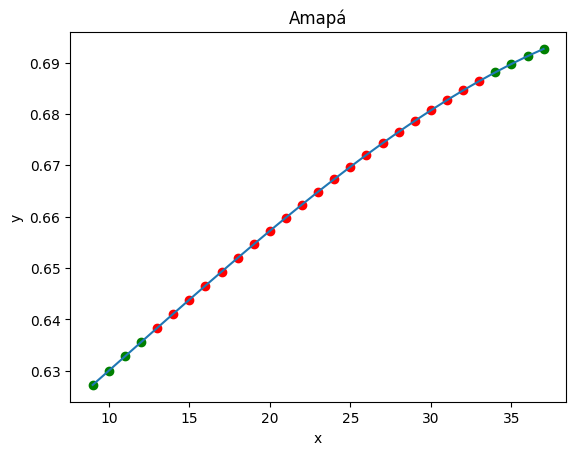

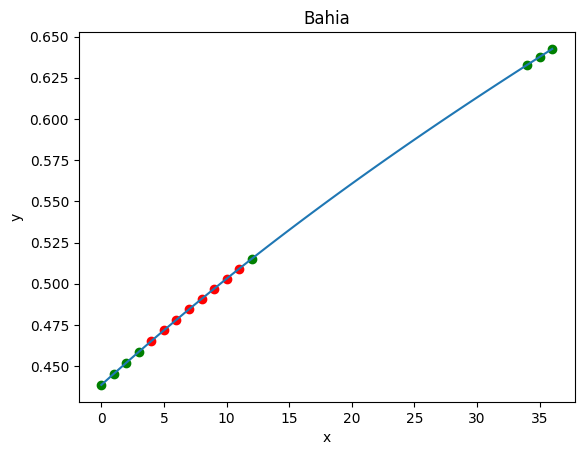

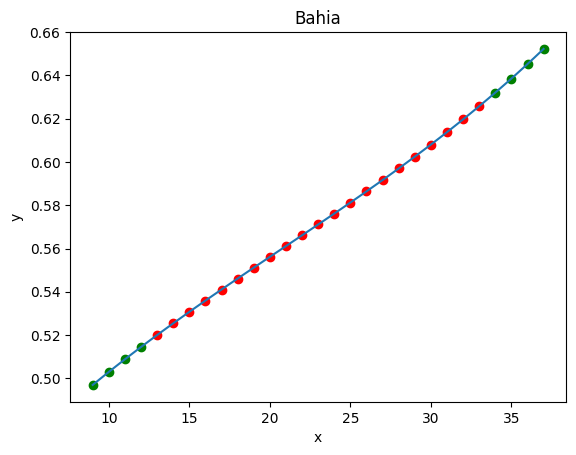

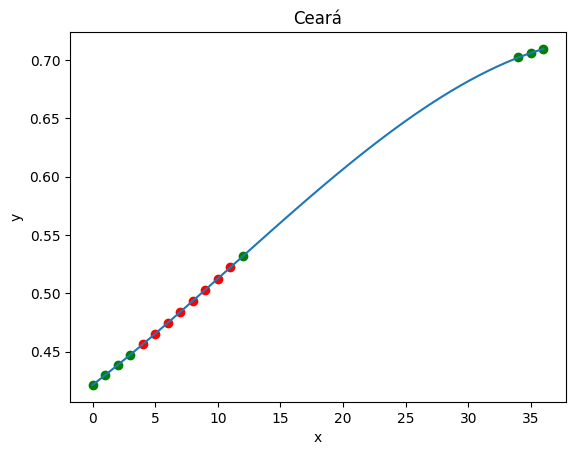

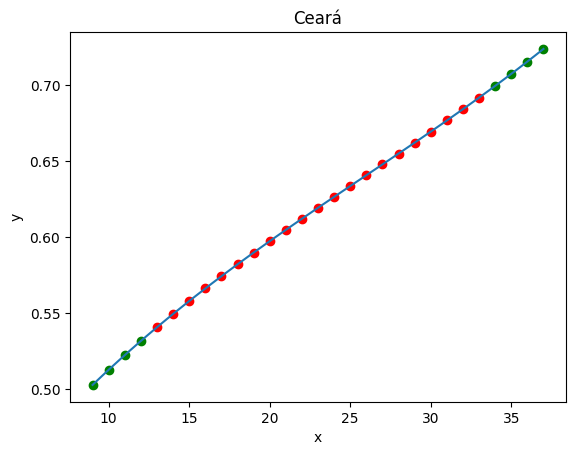

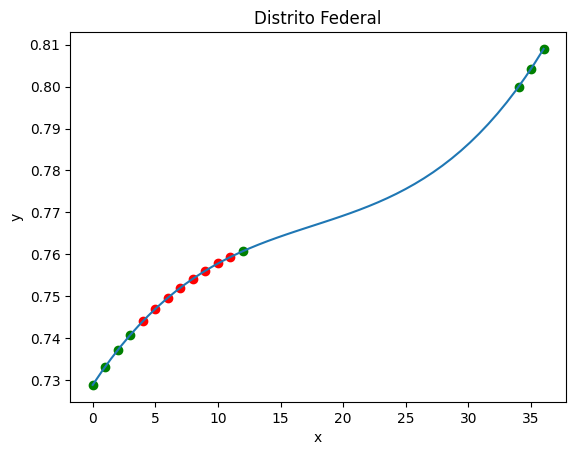

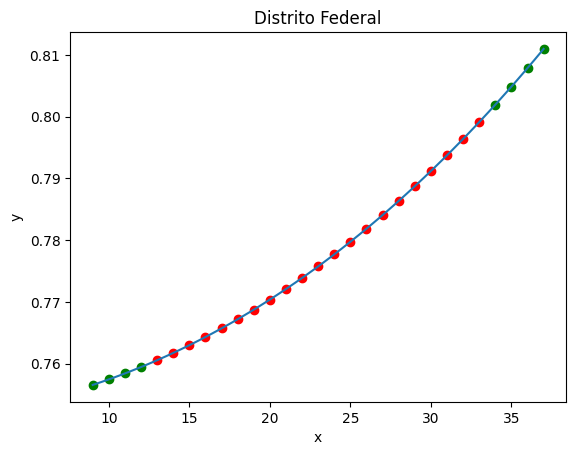

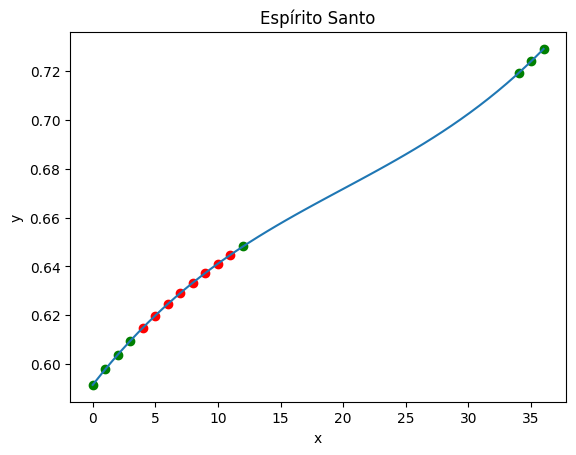

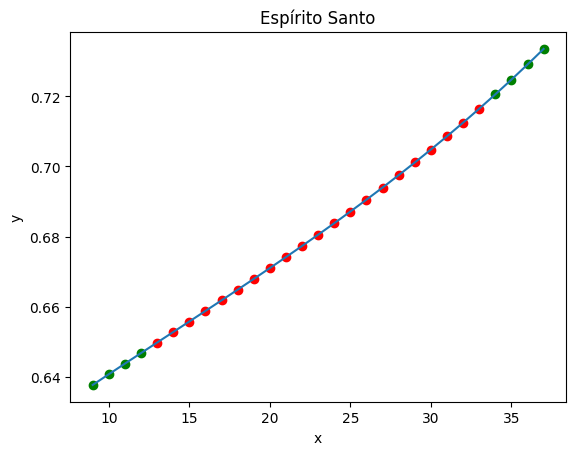

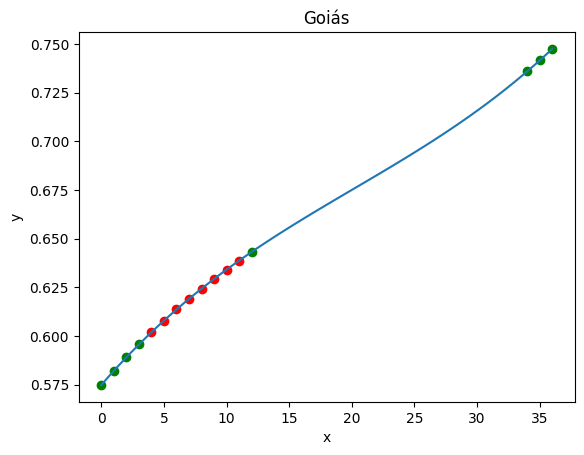

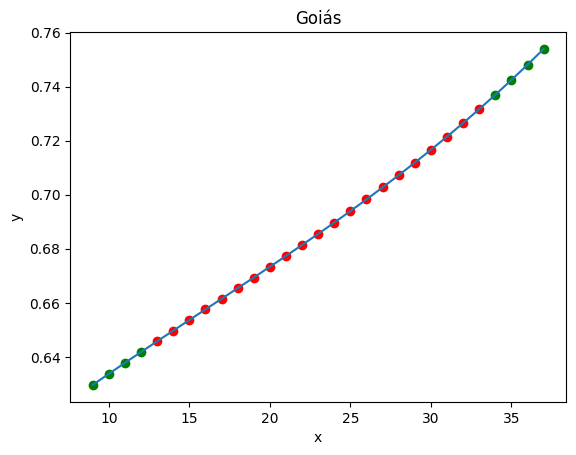

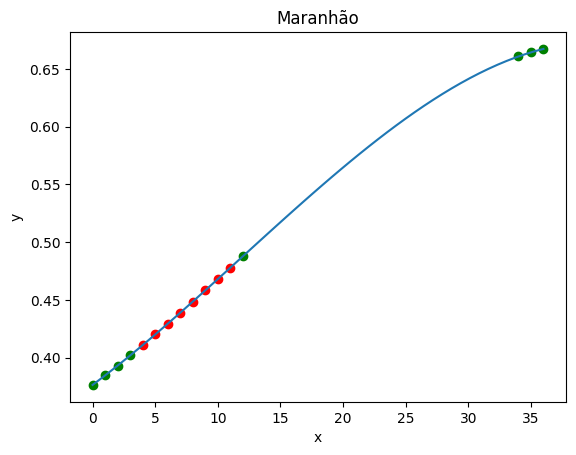

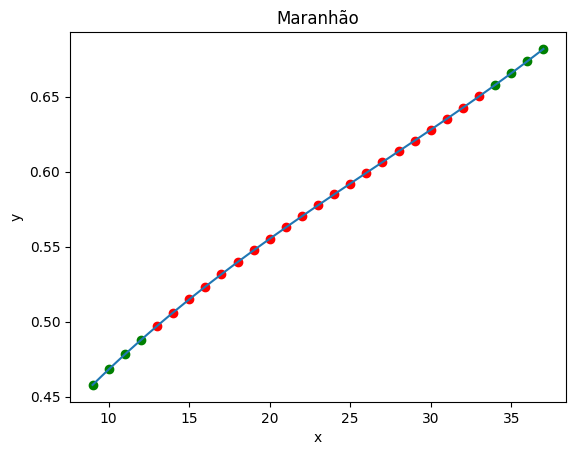

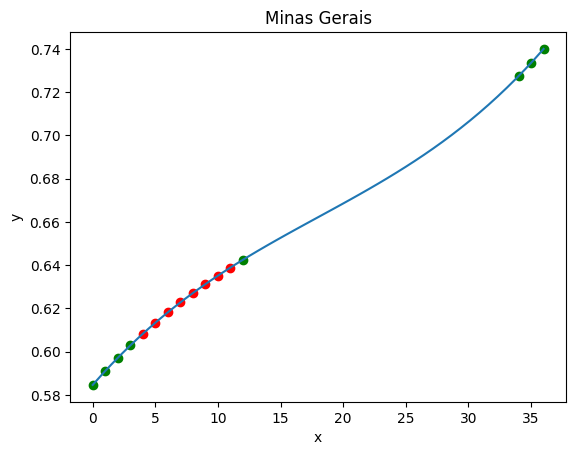

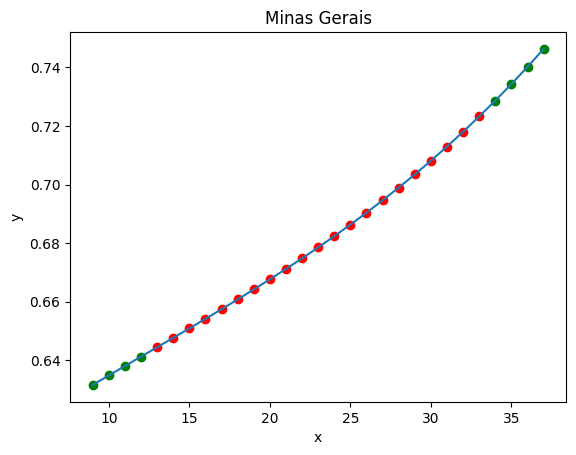

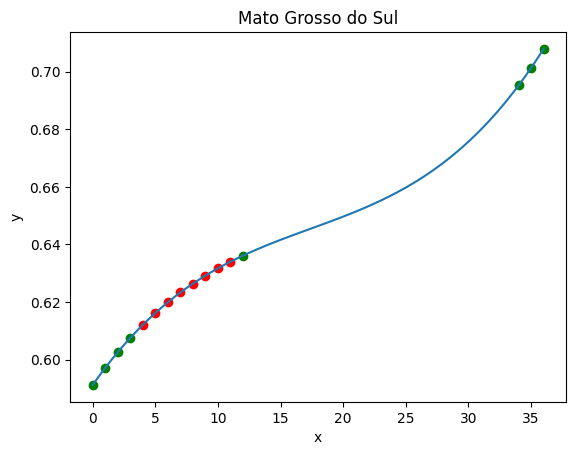

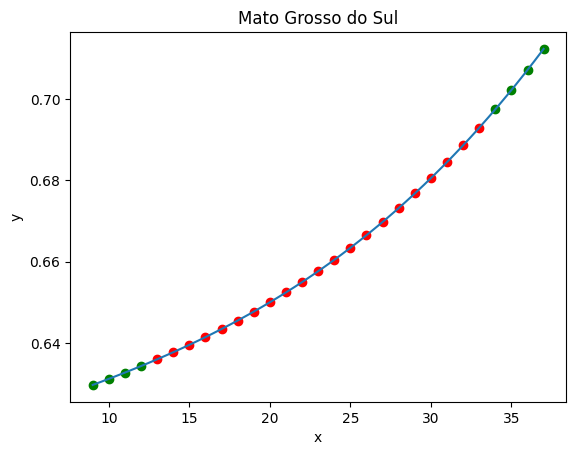

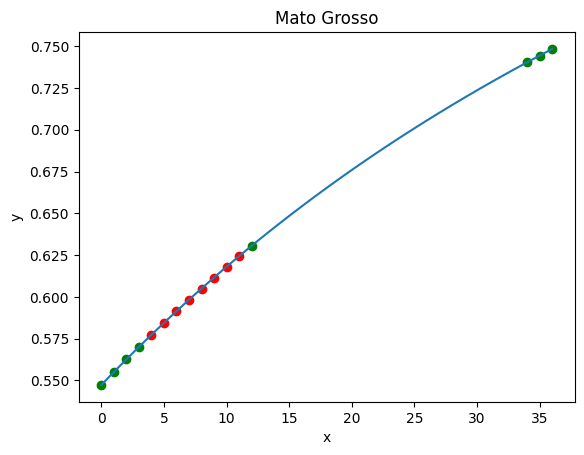

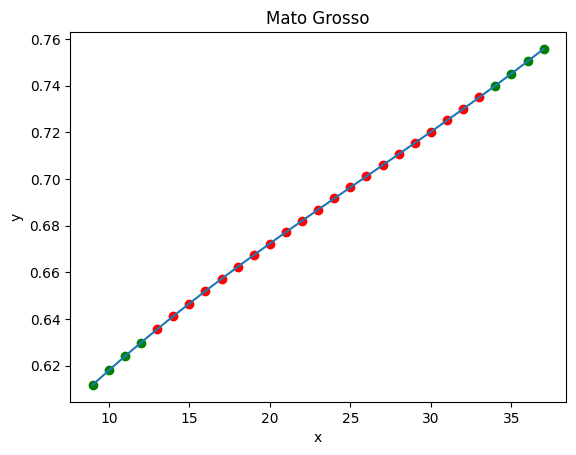

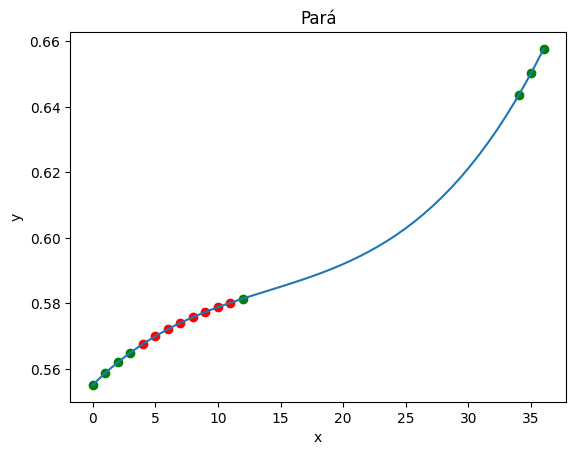

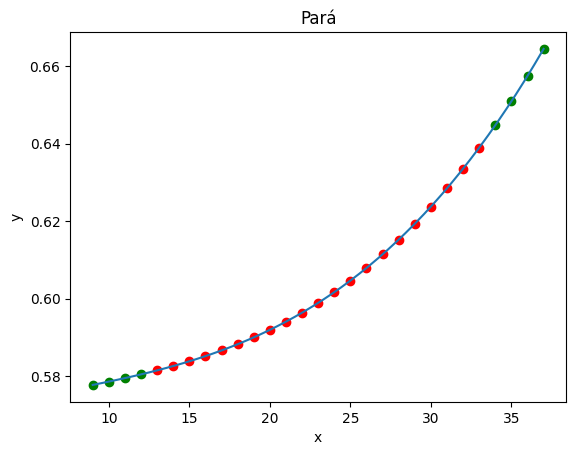

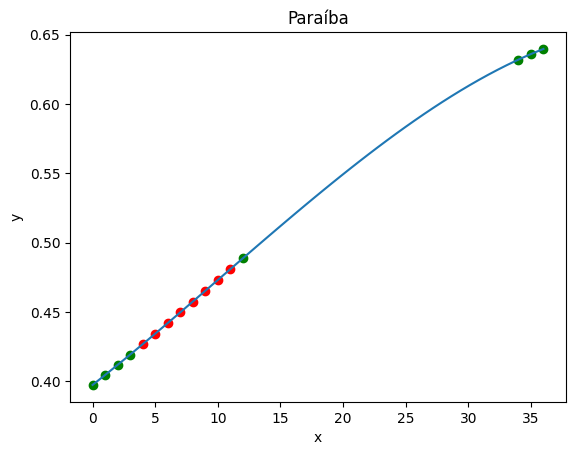

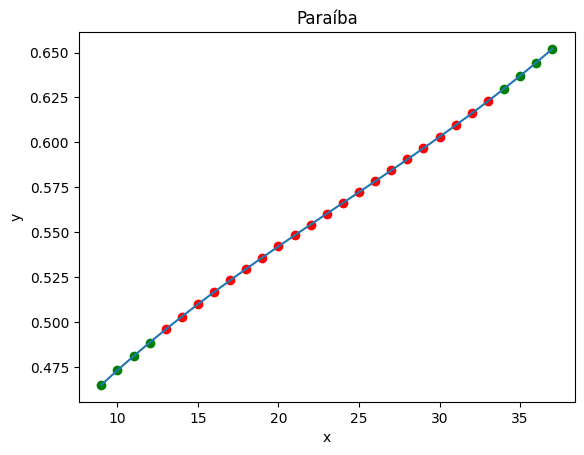

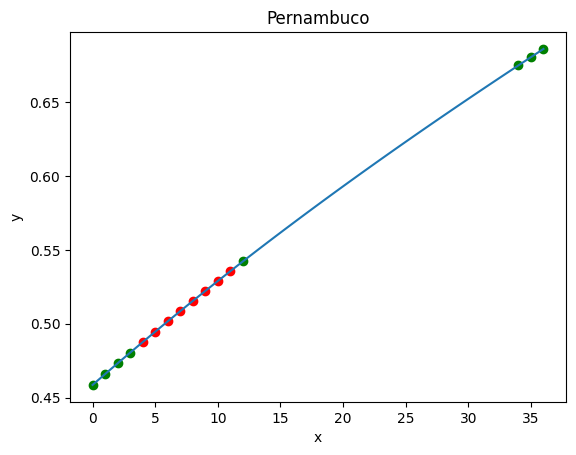

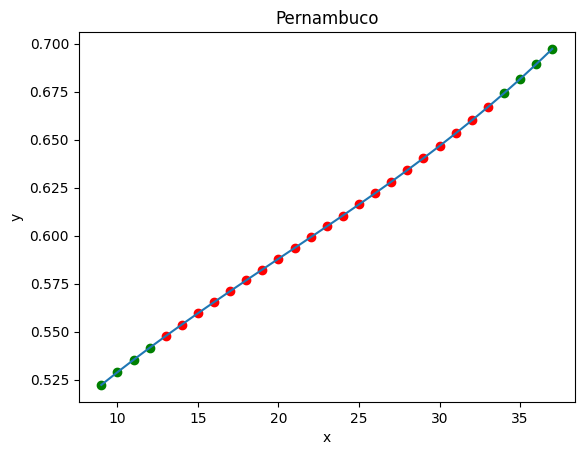

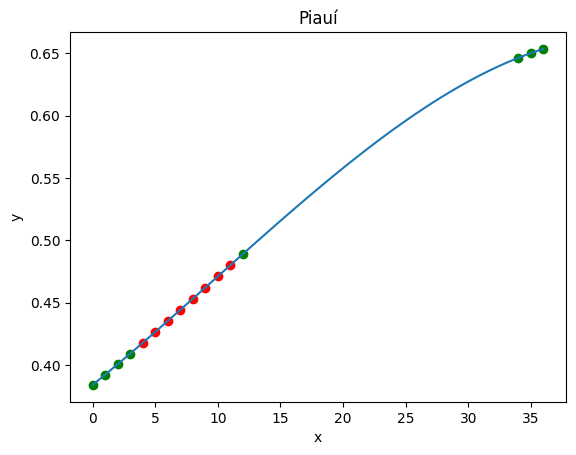

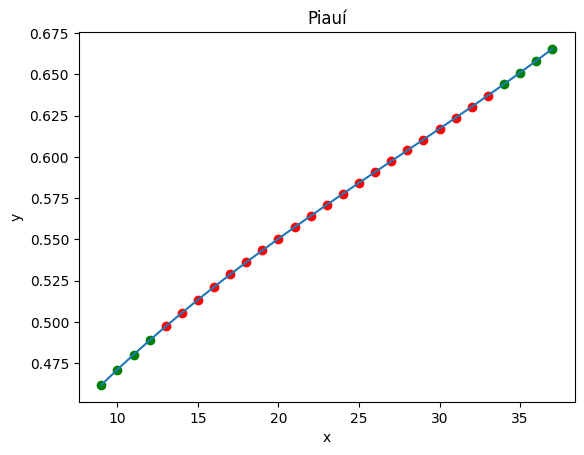

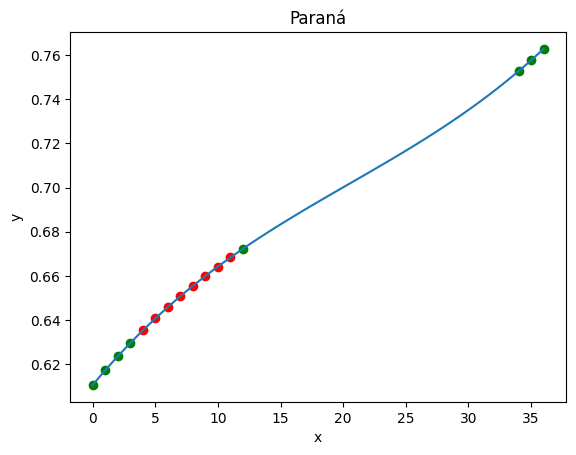

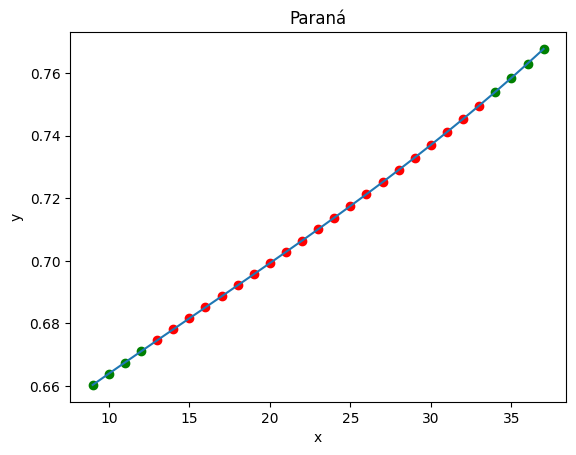

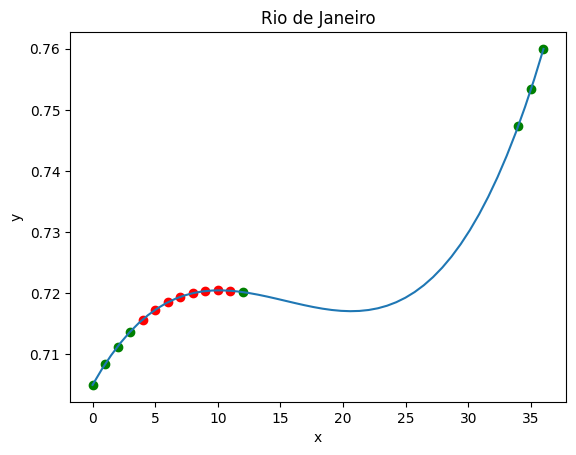

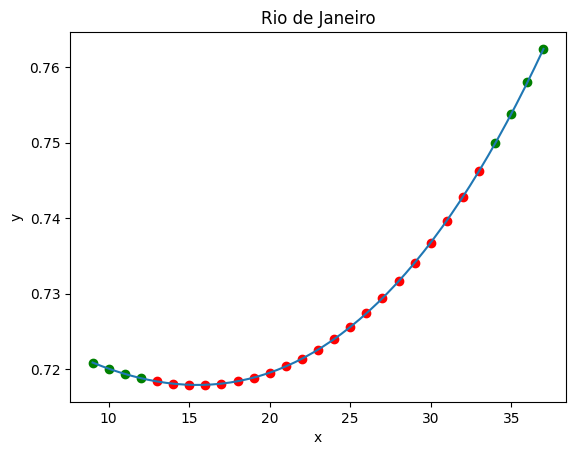

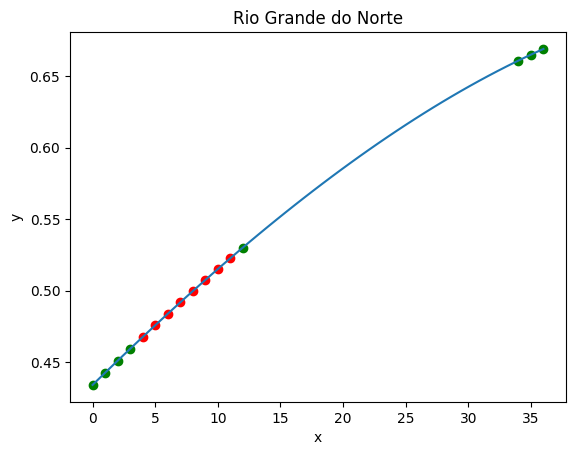

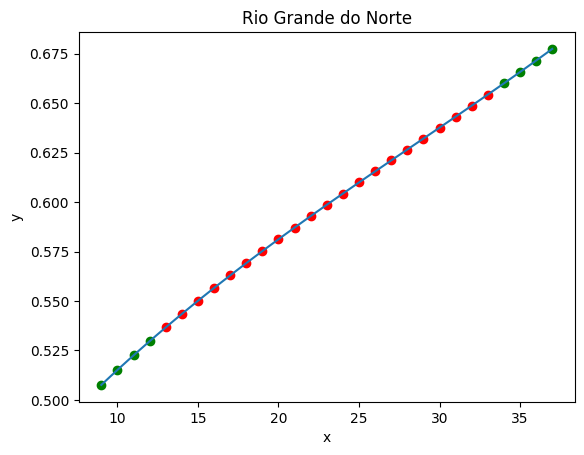

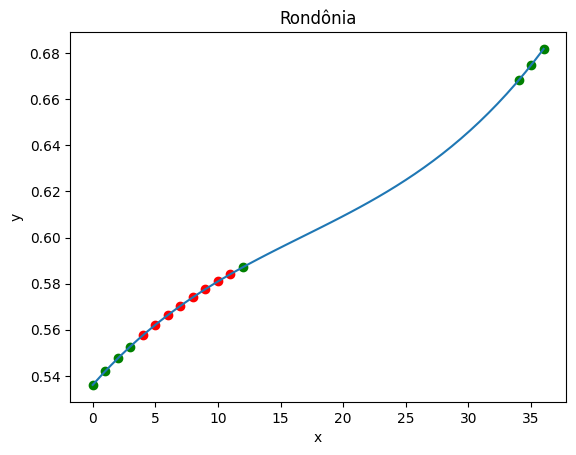

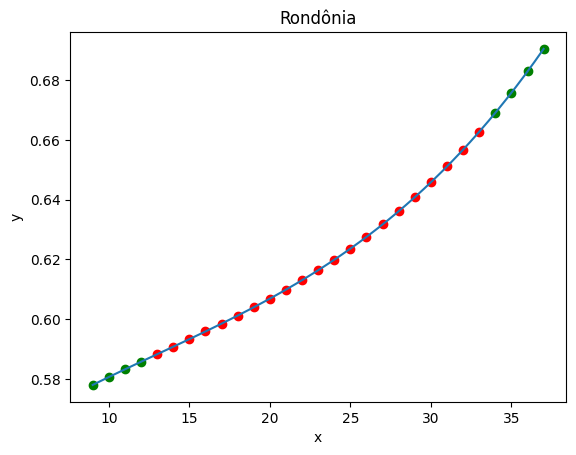

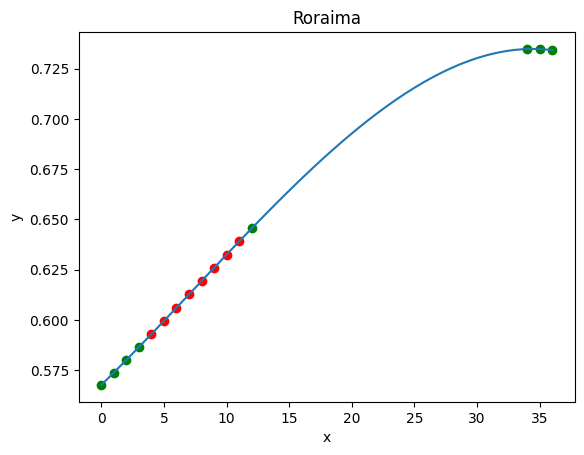

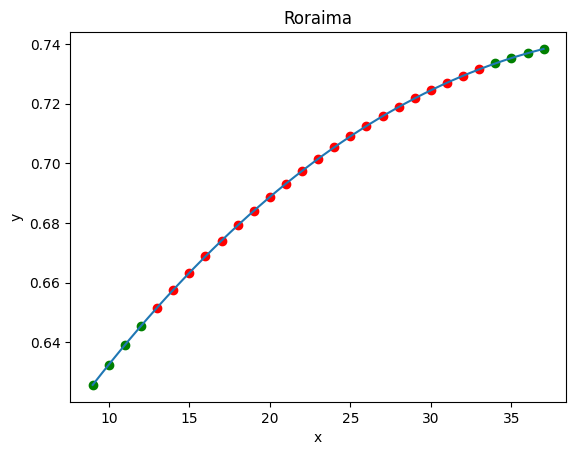

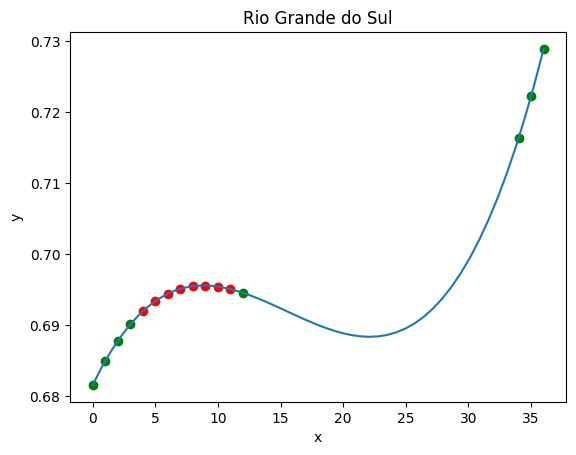

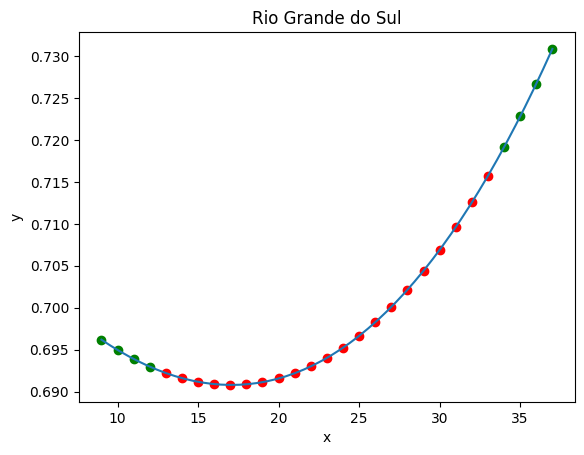

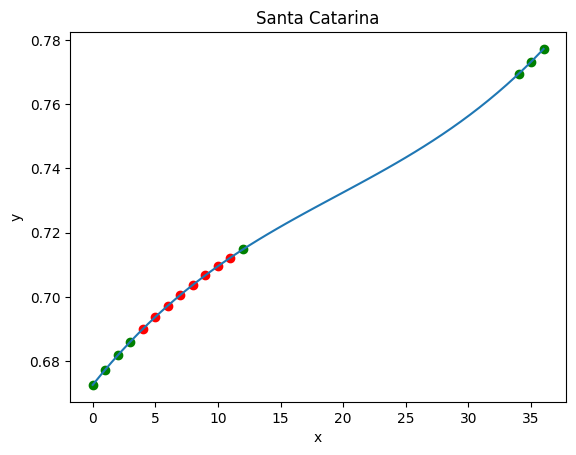

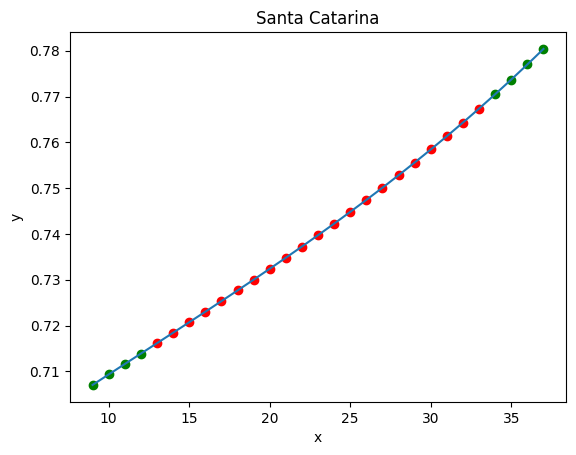

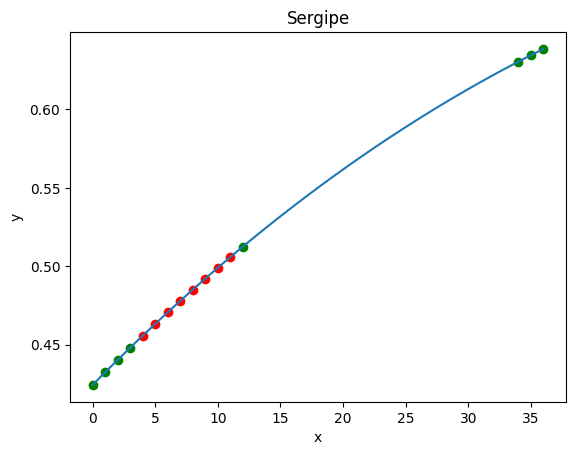

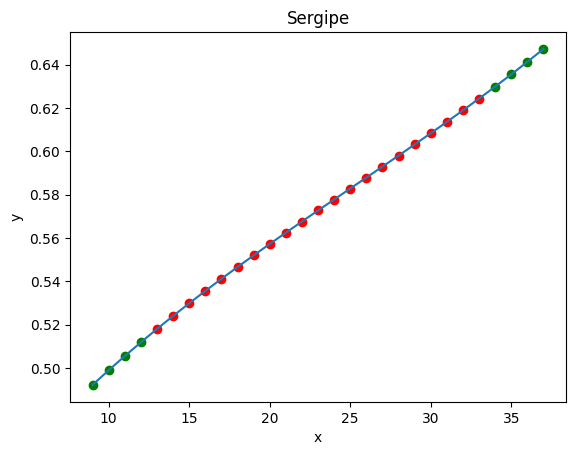

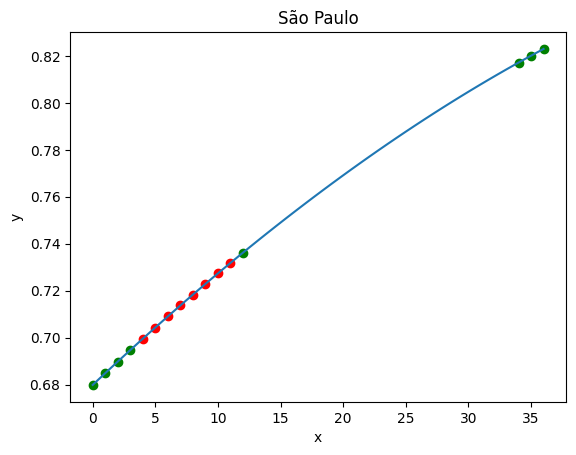

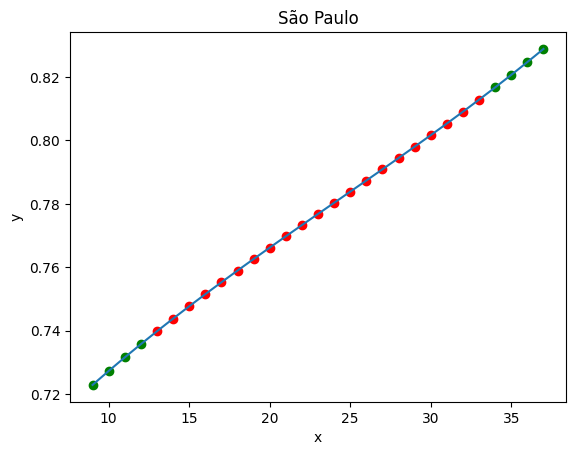

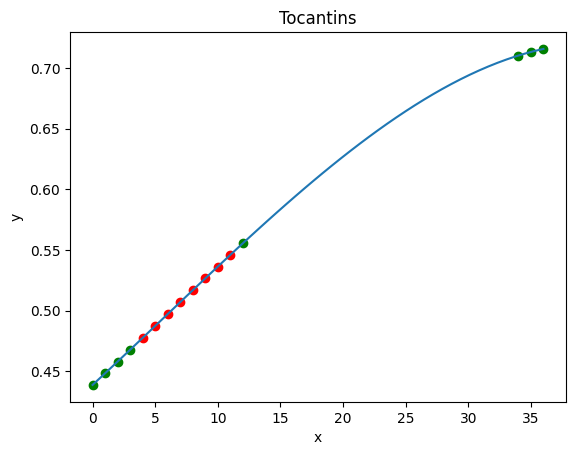

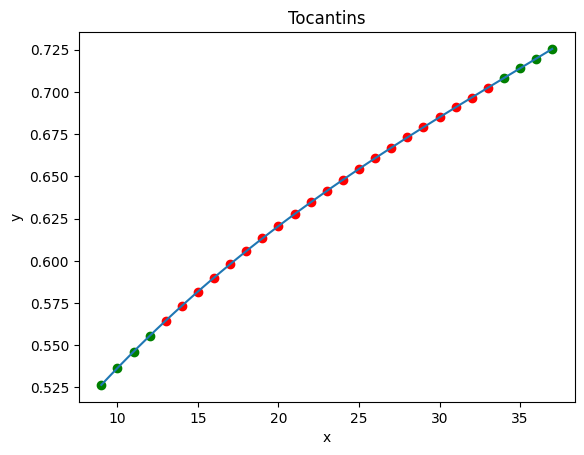

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1970,0.427909,0.359327,0.540945,0.577455,0.434236,0.416964,0.722418,0.584709,0.567655,0.372982,...,0.603327,0.699836,0.429091,0.531455,0.564036,0.675527,0.667600,0.419800,0.676200,0.435055
1980,0.444891,0.374193,0.556735,0.594945,0.449284,0.435356,0.737502,0.602651,0.587385,0.389178,...,0.622993,0.710804,0.448109,0.543345,0.578844,0.687833,0.681120,0.435960,0.688440,0.453665
1981,0.450469,0.379431,0.560081,0.598335,0.453940,0.440228,0.739802,0.606781,0.592063,0.394414,...,0.626591,0.713564,0.453331,0.549815,0.581412,0.690399,0.683944,0.442152,0.691328,0.459799
1982,0.455327,0.384008,0.562916,0.601183,0.457983,0.444419,0.741690,0.610301,0.596057,0.398969,...,0.629600,0.715932,0.457833,0.555559,0.583549,0.692570,0.686333,0.447582,0.693794,0.465140
1983,0.466131,0.394281,0.567392,0.605807,0.465258,0.456185,0.743990,0.614871,0.601867,0.410784,...,0.635262,0.715696,0.467733,0.557583,0.592920,0.691950,0.690015,0.455621,0.699534,0.477696
1984,0.474847,0.402569,0.571981,0.610512,0.471736,0.465320,0.746943,0.619903,0.607857,0.419973,...,0.640691,0.717285,0.475883,0.562118,0.599456,0.693384,0.693758,0.463157,0.704315,0.487502
1985,0.483588,0.410957,0.576383,0.614952,0.478139,0.474587,0.749604,0.624649,0.613573,0.429336,...,0.645858,0.718510,0.483941,0.566364,0.606037,0.694426,0.697287,0.470569,0.709041,0.497322
1986,0.492337,0.419428,0.580612,0.619139,0.484469,0.483966,0.751995,0.629126,0.619034,0.438847,...,0.650779,0.719407,0.491904,0.570347,0.612646,0.695114,0.700617,0.477859,0.713711,0.507139
1987,0.501080,0.427965,0.584687,0.623088,0.490727,0.493435,0.754141,0.633355,0.624258,0.448484,...,0.655472,0.720010,0.499770,0.574090,0.619264,0.695486,0.703763,0.485026,0.718325,0.516936


In [13]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df

In [17]:
df_2014 = df[df.index >= 2014]
df_2014

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
2014,0.683294,0.623692,0.701630,0.688817,0.641334,0.709103,0.806181,0.726354,0.744717,0.667134,...,0.760152,0.757247,0.667465,0.679551,0.734250,0.725779,0.775185,0.637414,0.821991,0.715187
2015,0.697137,0.640614,0.714202,0.693808,0.654935,0.727986,0.811891,0.735243,0.756129,0.685993,...,0.769526,0.762756,0.679977,0.692944,0.740251,0.731292,0.781469,0.650007,0.830674,0.728452
2016,0.698785,0.643852,0.716766,0.694154,0.656292,0.731530,0.813972,0.736083,0.759232,0.689356,...,0.771574,0.763734,0.679702,0.695575,0.738638,0.732591,0.782603,0.651553,0.832462,0.730402
2017,0.698311,0.644657,0.717836,0.692804,0.656319,0.733669,0.813243,0.736454,0.759707,0.690843,...,0.771445,0.764346,0.680039,0.695991,0.735696,0.733554,0.782385,0.653967,0.832050,0.731075
2018,0.700794,0.645625,0.716548,0.692150,0.656439,0.735366,0.814719,0.736950,0.761226,0.691465,...,0.772121,0.764560,0.680315,0.695718,0.733123,0.734150,0.782783,0.655327,0.832600,0.731263
2019,0.700321,0.645137,0.716507,0.687618,0.656115,0.734945,0.815330,0.736400,0.761610,0.692053,...,0.771678,0.763065,0.679434,0.694874,0.729406,0.733981,0.783036,0.654902,0.832927,0.730378
2020,0.697805,0.645331,0.714826,0.683947,0.654671,0.734485,0.812905,0.735982,0.760848,0.690966,...,0.771012,0.761525,0.678565,0.693772,0.725989,0.733889,0.782040,0.656348,0.831466,0.728867
2021,0.692787,0.643997,0.711810,0.682397,0.651459,0.731620,0.811806,0.733980,0.758198,0.687782,...,0.769195,0.759755,0.675707,0.689296,0.722988,0.733424,0.781316,0.654016,0.830054,0.725764
2022,0.692859,0.640815,0.711066,0.685615,0.650774,0.728495,0.811334,0.733251,0.756397,0.685216,...,0.768213,0.759915,0.675317,0.688869,0.727532,0.731917,0.780526,0.651290,0.829241,0.725197


In [18]:
for column in df_2014.columns:
    state = column
    file_name = f"2014_01_idh_educ_{state}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)